# Explainable AI – Unidad 2 - Fase 1 y 2

**Autores:** Jordi Florit Ensenyat · Josep Gabriel Fornes Reynes · Juan Esteban Rincón Marín  
**Asignatura:** Inteligencia Artificial Explicable — Hands-on Project (U2)  
**Fecha:** 28-09-2025

In [77]:
import sys
if 'google.colab' in sys.modules:
  !pip install -q dtreeviz
!pip install interpret six graphviz pydotplus

# Exploración inicial de los datos
Antes de entrenar el modelo, queremos entender la estructura del dataset:
- Número de instancias y variables (`df.info()`).
- Tipos de variables (categóricas, numéricas, binarias).
- Distribución de la variable objetivo (¿balanceada o desbalanceada?).

Esto nos ayuda a anticipar posibles problemas en el modelo, como sesgo hacia la clase mayoritaria.


In [78]:
import pandas as pd

df = pd.read_csv("recidivism.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222 entries, 0 to 4221
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sex                    4222 non-null   int64 
 1   age                    4222 non-null   int64 
 2   juv_fel_count          4222 non-null   int64 
 3   juv_misd_count         4222 non-null   int64 
 4   juv_other_count        4222 non-null   int64 
 5   priors_count           4222 non-null   int64 
 6   race_African-American  4222 non-null   int64 
 7   race_Caucasian         4222 non-null   int64 
 8   c_charge_degree_F      4222 non-null   int64 
 9   c_charge_degree_M      4222 non-null   int64 
 10  employment             4222 non-null   object
 11  recid                  4222 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 395.9+ KB


,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Caucasian,c_charge_degree_F,c_charge_degree_M,employment,recid
0,0,45,0,0,0,1,0,1,1,0,unemployed,1
1,1,43,0,0,0,2,1,0,0,1,unemployed,0
2,0,26,0,0,0,0,1,0,1,0,employed,0
3,1,35,0,0,0,1,0,1,1,0,unemployed,1
4,1,27,0,0,0,0,1,0,1,0,unemployed,1


## División de datos (train-test) y Definición del Modelo Base

En esta sección, preparamos los datos para el entrenamiento del modelo y definimos la estructura básica del clasificador de árbol de decisión.

1.  **División de Datos:** Dividimos el dataset en conjuntos de entrenamiento y prueba (`X_train`, `X_test`, `y_train`, `y_test`). La división se realiza utilizando `train_test_split` con un 30% de los datos para prueba y estratificación por la variable objetivo (`recid`) para mantener las proporciones de clase.

2.  **Definición del Modelo Base:** Importamos `DecisionTreeClassifier` de scikit-learn. Aunque en este punto aún no hemos definido los hiperparámetros óptimos, preparamos la importación de la función necesaria para la construcción del modelo.

In [79]:
!pip install interpret

In [80]:
# --- Bibliotecas de manipulación de datos y numéricas ---
import numpy as np
import pandas as pd

# --- Bibliotecas de visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# --- Componentes de Scikit-Learn ---
# Preprocesamiento y selección de modelos
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Modelos
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Métricas de evaluación
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

# --- Biblioteca InterpretML para explicabilidad ---
from interpret import show
from interpret.glassbox import (ClassificationTree,
                                  ExplainableBoostingClassifier)

In [81]:
# Definir target y variables predictoras
X = df.drop(columns=["recid"])   # Todas las columnas menos la variable objetivo
y = df["recid"]

# Dividir en train (70%) y test/valid (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,         # porcentaje para el test
    random_state=42,        # semilla para reproducibilidad
    stratify=y              # asegura que las proporciones de clases se mantengan
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2955, 11) (2955,)
Test shape: (1267, 11) (1267,)


# Preprocesamiento de los datos
En este paso definimos:
- **Variables categóricas**: se codifican mediante *OneHotEncoder*.
- **Variables numéricas**: no requieren escalado para árboles, pero podrían normalizarse si se combinan con otros algoritmos.
- **Pipeline**: asegura que todo el flujo (preprocesamiento + modelo) se ejecute de forma coherente en entrenamiento y test.

In [82]:
# Preprocesamiento: numéricas (passthrough), categóricas (One-Hot)
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Logical classifiers
- tree
- lists
- sets

# Decision Tree Classifier

In [83]:
# Pipeline: preprocesamiento + modelo
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("dt", DecisionTreeClassifier(random_state=42))
])

## Decision Tree Classifier simple
Entrenamos un primer modelo base (sin tuning) para establecer un punto de comparación.
Este baseline nos permitirá medir cuánto mejora el rendimiento tras aplicar **GridSearchCV**.


Accuracy (valid): 0.6590

== Classification report (valid) ==
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       674
           1       0.65      0.59      0.62       593

    accuracy                           0.66      1267
   macro avg       0.66      0.65      0.65      1267
weighted avg       0.66      0.66      0.66      1267

== Confusion matrix (valid) ==


[]

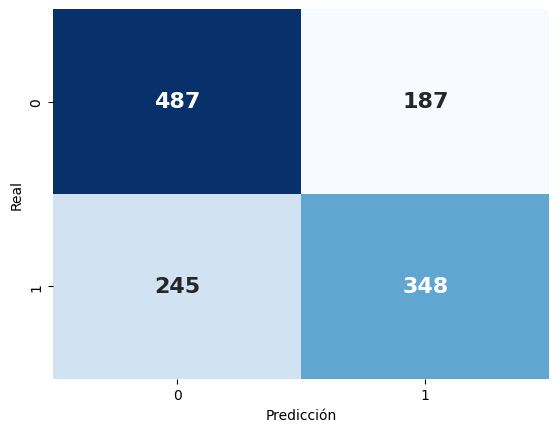

In [84]:
# Entrenar
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (valid): {acc:.4f}\n")

print("== Classification report (valid) ==")
print(classification_report(y_test, y_pred))

print("== Confusion matrix (valid) ==")
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16, "weight": "bold"});ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.plot()

In [85]:
# Asumiendo que ya tienes entrenado el árbol en 'model'
# Access the DecisionTreeClassifier from the pipeline
decision_tree_model = clf.named_steps['dt']

# Get feature names after preprocessing
# This requires fitting the preprocessor separately or getting feature names from the pipeline
# For simplicity, let's use the original feature names for now, but be aware of one-hot encoding
# A more robust solution would involve getting feature names from the preprocessor after fitting

# Get feature names from the preprocessor after fitting
# This is a bit more complex because OneHotEncoder changes the feature names
# A simpler approach for visualization might be to use the original feature names
# but the visualization won't reflect the one-hot encoded features

# Let's use the feature names from the fitted preprocessor
try:
    # This works for newer versions of scikit-learn
    feature_names_out = clf.named_steps['prep'].get_feature_names_out(X.columns)
except AttributeError:
    # Fallback for older versions - might not be perfect
    feature_names_out = list(X.columns)


rules = export_text(decision_tree_model, feature_names=list(feature_names_out))
print(rules)

|--- cat__employment_unemployed <= 0.50
|   |--- num__priors_count <= 20.00
|   |   |--- num__sex <= 0.50
|   |   |   |--- num__priors_count <= 2.50
|   |   |   |   |--- num__age <= 21.50
|   |   |   |   |   |--- num__c_charge_degree_M <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- num__c_charge_degree_M >  0.50
|   |   |   |   |   |   |--- num__priors_count <= 0.50
|   |   |   |   |   |   |   |--- num__race_Caucasian <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- num__race_Caucasian >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- num__priors_count >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- num__age >  21.50
|   |   |   |   |   |--- num__c_charge_degree_F <= 0.50
|   |   |   |   |   |   |--- num__age <= 62.00
|   |   |   |   |   |   |   |--- num__age <= 40.50
|   |   |   |   |   |   |   |   |--- num__age <= 27.50
|   |   |   |   |   |   |   |   |   |--- num__ag

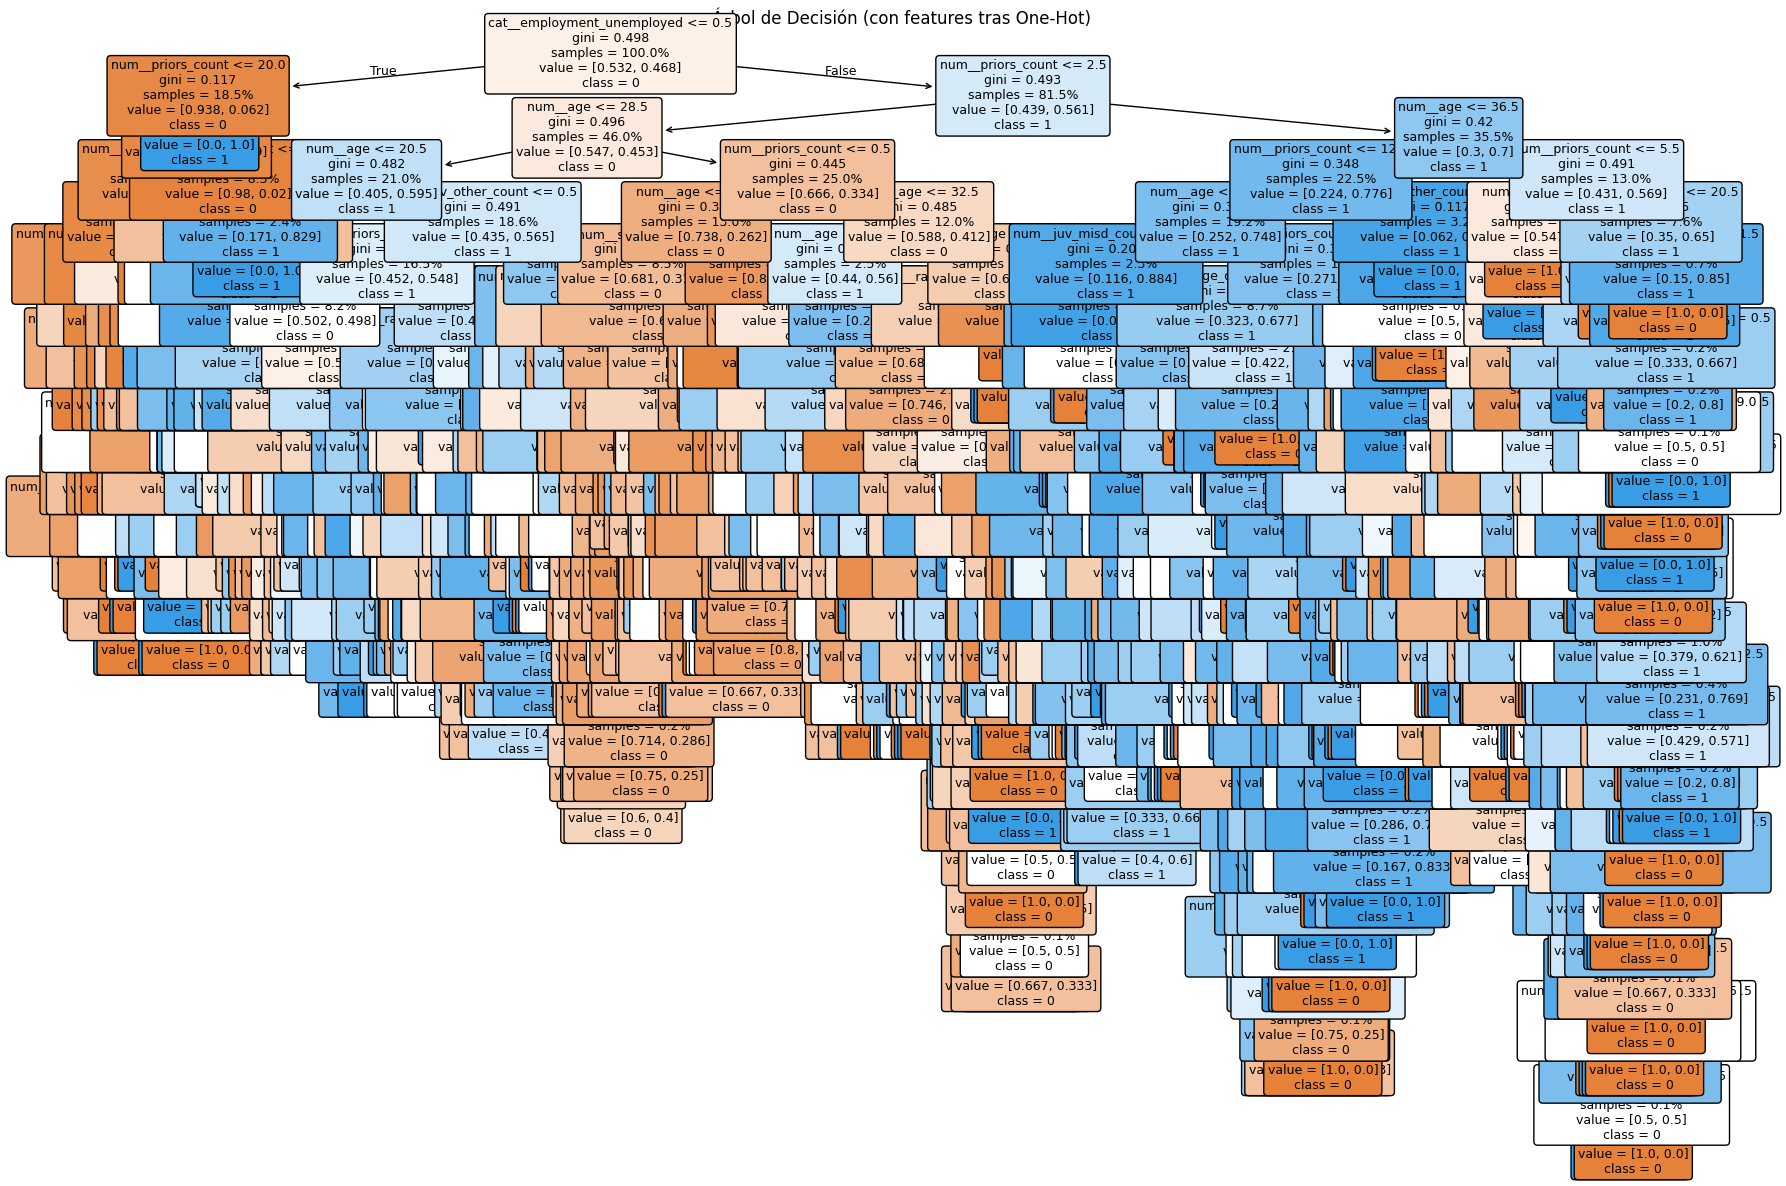

In [86]:
# Aseguramos nombres de clase legibles (en el mismo orden que usa el modelo)
classes_ = getattr(decision_tree_model, "classes_", None)
if classes_ is None:
    # fallback por si acaso
    classes_ = np.unique(y_train)

plt.figure(figsize=(18, 12))
plot_tree(
    decision_tree_model,
    feature_names=feature_names_out,        # nombres tras One-Hot/ColumnTransformer
    class_names=[str(c) for c in classes_], # etiquetas de clase
    filled=True,
    rounded=True,
    impurity=True,      # gini/entropy en nodos (puedes poner False si lo quieres más limpio)
    proportion=True,    # muestra proporción de muestras por nodo
    fontsize=9
)
plt.title("Árbol de Decisión (con features tras One-Hot)")
plt.tight_layout()
plt.show()


Como podemos ver, el árbol resultante no es nada explicable. Además, no nos da muy buenos resultados.

## GridSearchCV y validación cruzada
- Usamos validación cruzada estratificada (5 folds) para garantizar que las proporciones de clases se mantengan.  
- Buscamos entre distintos hiperparámetros (`criterion`, `max_depth`, `min_samples_split`, etc.).  
- El mejor modelo se selecciona en base a la métrica de **balanced accuracy**, que es más robusta en datasets desbalanceados.


Fitting 5 folds for each of 4032 candidates, totalling 20160 fits
Mejores parámetros: {'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_features': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2, 'dt__splitter': 'best'}
Mejor CV (balanced_acc): 0.7191
Accuracy (test): 0.6961
Balanced Acc (test): 0.7019

== Classification report (test) ==
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       674
           1       0.64      0.79      0.71       593

    accuracy                           0.70      1267
   macro avg       0.71      0.70      0.70      1267
weighted avg       0.71      0.70      0.69      1267

== Confusion matrix (test) ==


[]

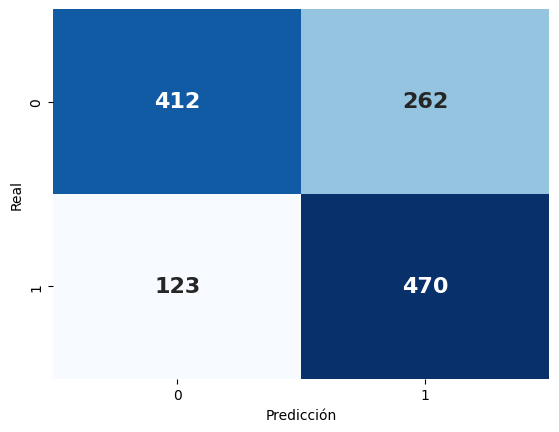

In [87]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Esquema de CV estratificado (pide 5-fold en el enunciado)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Rejilla de hiperparámetros del árbol (ajústala si el tiempo es justo)
param_grid = {
    "dt__criterion": ["gini", "entropy", "log_loss"],
    "dt__max_depth": [None, 3, 4, 5, 6, 8, 10],
    "dt__min_samples_split": [2, 5, 10, 20],
    "dt__min_samples_leaf": [1, 2, 5, 10],
    "dt__max_features": [None, "sqrt", "log2"],  # sólo sobre features ya preprocesadas
    "dt__class_weight": [None, "balanced"],      # útil si hay desbalanceo
    "dt__splitter": ["best", "random"]
}

# Métrica: si es binaria y hay desbalanceo, usa balanced_accuracy o roc_auc
grid = GridSearchCV(
    estimator=clf,                # tu Pipeline (prep + dt)
    param_grid=param_grid,
    scoring="balanced_accuracy",  # cambia a "roc_auc" si prefieres AUC
    n_jobs=-1,
    cv=cv,
    refit=True,                   # deja el mejor modelo refitteado en .best_estimator_
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print(f"Mejor CV (balanced_acc): {grid.best_score_:.4f}")

# Evalúa SÓLO ahora en test (hold-out)
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
print(f"Accuracy (test): {accuracy_score(y_test, y_pred):.4f}")
print(f"Balanced Acc (test): {balanced_accuracy_score(y_test, y_pred):.4f}")
print("\n== Classification report (test) ==")
print(classification_report(y_test, y_pred))
print("== Confusion matrix (test) ==")
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16, "weight": "bold"});ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.plot()


### Visualización de árbol

|--- cat__employment_unemployed <= 0.50
|   |--- num__priors_count <= 20.00
|   |   |--- num__sex <= 0.50
|   |   |   |--- class: 0
|   |   |--- num__sex >  0.50
|   |   |   |--- class: 0
|   |--- num__priors_count >  20.00
|   |   |--- class: 1
|--- cat__employment_unemployed >  0.50
|   |--- num__priors_count <= 2.50
|   |   |--- num__age <= 28.50
|   |   |   |--- class: 1
|   |   |--- num__age >  28.50
|   |   |   |--- class: 0
|   |--- num__priors_count >  2.50
|   |   |--- num__age <= 36.50
|   |   |   |--- class: 1
|   |   |--- num__age >  36.50
|   |   |   |--- class: 1



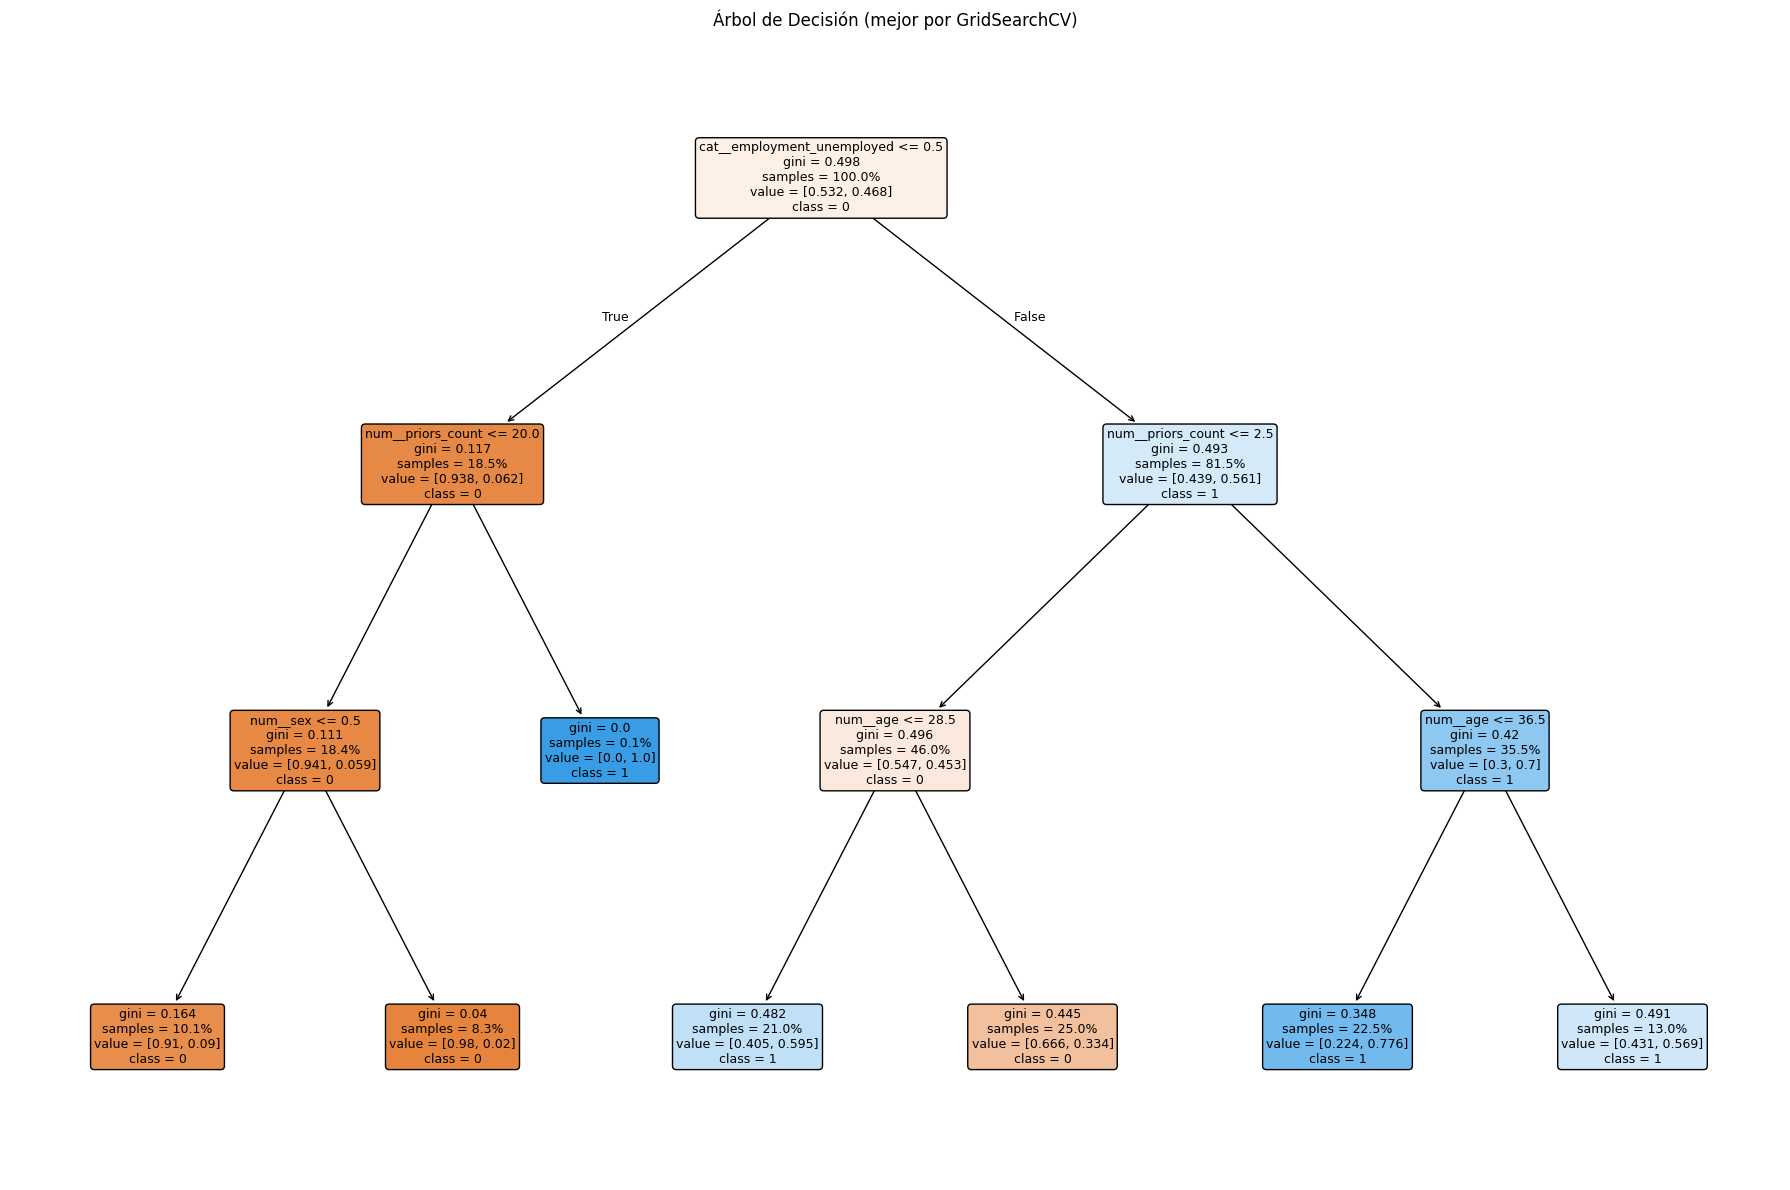

In [88]:
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
import numpy as np

best_dt = best_clf.named_steps["dt"]

# Nombres de features tras el preprocesado
feature_names_out = best_clf.named_steps["prep"].get_feature_names_out(X.columns)

# Reglas en texto
print(export_text(best_dt, feature_names=list(feature_names_out)))

# Plot
classes_ = getattr(best_dt, "classes_", np.unique(y_train))
plt.figure(figsize=(18, 12))
plot_tree(
    best_dt,
    feature_names=feature_names_out,
    class_names=[str(c) for c in classes_],
    filled=True, rounded=True, impurity=True, proportion=True, fontsize=9
)
plt.title("Árbol de Decisión (mejor por GridSearchCV)")
plt.tight_layout()
plt.show()


In [89]:
# 1) Extrae los hiperparámetros del árbol del GridSearch (prefijo dt__)
best_dt_params = {k.split("dt__")[1]: v for k, v in grid.best_params_.items() if k.startswith("dt__")}

# 2) Filtra solo los compatibles con ClassificationTree de interpret
allowed = {"max_depth", "min_samples_split", "min_samples_leaf"}
ct_params = {k: v for k, v in best_dt_params.items() if k in allowed}
ct_params.setdefault("random_state", 42)

# 3) Preprocesa X con 'prep' del pipeline ganador
prep = best_clf.named_steps["prep"]
Xtr_num = prep.transform(X_train)   # -> array/CSR con one-hot + numéricas
Xte_num = prep.transform(X_test)

# 4) Poner nombres de columnas para que las explicaciones sean legibles
import pandas as pd
feat_out = prep.get_feature_names_out(X_train.columns)
Xtr_df = pd.DataFrame(Xtr_num.toarray() if hasattr(Xtr_num, "toarray") else Xtr_num, columns=feat_out)
Xte_df = pd.DataFrame(Xte_num.toarray() if hasattr(Xte_num, "toarray") else Xte_num, columns=feat_out)

# 5) Entrenar el árbol de interpret con los mismos hiperparámetros compatibles
from interpret.glassbox import ClassificationTree
ct = ClassificationTree(**ct_params)
ct.fit(Xtr_df, y_train)

In [90]:
# Añadir exolicabilidad local
from interpret import show
global_exp = ct.explain_global(name="ClassificationTree · Global")
show(global_exp)

## Explicabilidad global

El árbol de decisión aprendido genera reglas claras y fáciles de explicar:

1. **Situación laboral (`employment_unemployed`)**  
   - Es la variable en la **raíz**, por tanto, la más influyente.  
   - Si el individuo **no está desempleado** (≤ 0.5), la predicción tiende a ser **clase 0 (no reincide)** salvo casos extremos.  
   - Si el individuo **está desempleado** (> 0.5), la rama principal se orienta hacia **clase 1 (reincide)** con matices según edad y antecedentes.

2. **Número de antecedentes (`num__priors_count`)**  
   - Si una persona con empleo tiene **más de 20 antecedentes**, se clasifica directamente como **clase 1 (reincide)**.  
   - En desempleados, el umbral se sitúa mucho más bajo (**2.5 antecedentes**) para diferenciar perfiles de bajo y alto riesgo.

3. **Edad (`num__age`)**  
   - Aparece en la rama de los desempleados:  
     - **≤ 28.5 años** con pocos antecedentes ⇒ **clase 1** (riesgo alto por juventud).  
     - **> 28.5 años** con pocos antecedentes ⇒ **clase 0** (la edad mitiga el riesgo).  
     - Con más antecedentes, incluso los **mayores de 36.5 años** siguen siendo clasificados como reincidentes.

4. **Sexo (`num__sex`)**  
   - Aparece solo en la rama de personas empleadas con ≤ 20 antecedentes.  
   - Tanto hombres como mujeres terminan siendo clasificados como **clase 0**, aunque el nodo ajusta ligeramente la pureza.

**Reglas principales extraídas:**

- **R1.** Si `employment_unemployed ≤ 0.5` y `num__priors_count ≤ 20` ⇒ **Clase 0 (no reincide)**.  
- **R2.** Si `employment_unemployed ≤ 0.5` y `num__priors_count > 20` ⇒ **Clase 1 (reincide)**.  
- **R3.** Si `employment_unemployed > 0.5` y `num__priors_count ≤ 2.5`:  
  - Si `edad ≤ 28.5` ⇒ **Clase 1**.  
  - Si `edad > 28.5` ⇒ **Clase 0**.  
- **R4.** Si `employment_unemployed > 0.5` y `num__priors_count > 2.5`:  
  - Si `edad ≤ 36.5` ⇒ **Clase 1**.  
  - Si `edad > 36.5` ⇒ **Clase 1** (con mayor incertidumbre).

**Ranking de importancia (inferido):**
1. Situación laboral  
2. N.º de antecedentes  
3. Edad  
4. Sexo (mínima relevancia)

### Explicabilidad local
Para un caso individual, podemos seguir la ruta de decisión:
- Ver qué reglas se aplican en cada nodo.
- Entender por qué la predicción final es positiva o negativa.

Esto aporta **explicabilidad local**.

Para este apartado usamos el árbol de **InterpretMl**, para poder usar el metodo _explain_local()_ necesitamos entrenar un árbol entrenado de la libreria **InterpretMl** con los mejores parámetros encontrados en el greed-search.


In [91]:
# Añadir exolicabilidad local
local_exp = ct.explain_local(Xte_df.iloc[:5], y_test.iloc[:5], name="ClassificationTree · Local (5 casos)")
show(local_exp)


Ahora podemos observar 5 ejemplos reales de test, la clase que se ha predecido, la real y las reglas que se ha seguido en cada caso.

## Caso 0 — *Falso positivo*
**0 : Actual (0) | Predicted (1) | PrScore 0.776**

**Ruta seguida:**
1. `unemployed = 1` (rama derecha).
2. `num__priors_count <= 2.50` (pocos antecedentes).
3. `num__age <= 36.50` → hoja **naranja (clase 1)**.

**Lectura:** El modelo **sube el riesgo** (1) cuando la persona está **desempleada**, tiene **pocos antecedentes** y es **≤ 36.5 años**. Aquí se **equivoca** (era 0) pero con **confianza alta** (0.776).

## Caso 1 — *Verdadero negativo*
**1 : Actual (0) | Predicted (0) | PrScore 0.666**

**Ruta seguida:**
1. `unemployed = 1`.
2. `num__priors_count <= 2.50`.
3. `num__age <= 28.50` → hoja **azul (clase 0)**.

**Lectura:** Dentro de *desempleados + pocos antecedentes*, si la **edad es muy baja (≤ 28.5)** el árbol **baja el riesgo** y clasifica como 0.

## Caso 2 — *Verdadero positivo*
**2 : Actual (1) | Predicted (1) | PrScore 0.776**

**Ruta seguida:**
1. `unemployed = 1`.
2. `num__priors_count <= 2.50`.
3. `num__age <= 36.50` → **clase 1**.

**Lectura:** Misma subregla que en el Caso 0, pero aquí **acierta**: *desempleo + juventud relativa* activan 1 incluso con pocos antecedentes.

## Caso 3 — *Falso negativo*
**3 : Actual (1) | Predicted (0) | PrScore 0.666**

**Ruta seguida:**
1. `unemployed = 1`.
2. `num__priors_count <= 2.50`.
3. `num__age <= 28.50` → **clase 0**.

**Lectura:** Igual que el Caso 1, pero la verdad era 1. La subregla “**muy joven (≤ 28.5)**, **pocos antecedentes**, **desempleado**” **tiende a infraestimar** el riesgo en algunos casos.

## Caso 4 — *Verdadero negativo*
**4 : Actual (0) | Predicted (0) | PrScore 0.666**

**Ruta seguida:**
1. `unemployed = 1`.
2. `num__priors_count <= 2.50`.
3. `num__age <= 28.50` → **clase 0**.

**Lectura:** Repite el patrón de **baja edad → clase 0** dentro del subgrupo *desempleado + pocos antecedentes*.



# Lineality study

Antes de aplicar un modelo linea o GAM, queremos saber que nos conviene más. Para eso vamos a realizar un estudio de las distintas variables que tenemos en nuestro dataset

In [92]:
import pandas as pd

try:
    df_train = pd.read_csv("recidivism.csv")
    print("Dataset de entrenamiento 'recidivism.csv' cargado correctamente.")
    df_test = pd.read_csv("test.csv")
    print("Nuevo dataset de test 'test.csv' cargado correctamente.")
except FileNotFoundError:
    print("Error: Asegúrate de que los archivos 'recidivism.csv' y 'test.csv' están en el mismo directorio.")
    exit()

# Separar predictores y objetivo del dataset de entrenamiento completo
X_train_full = df_train.drop(columns=["recid"])
y_train_full = df_train["recid"]

Dataset de entrenamiento 'recidivism.csv' cargado correctamente.
Nuevo dataset de test 'test.csv' cargado correctamente.


## Matriz de correlación

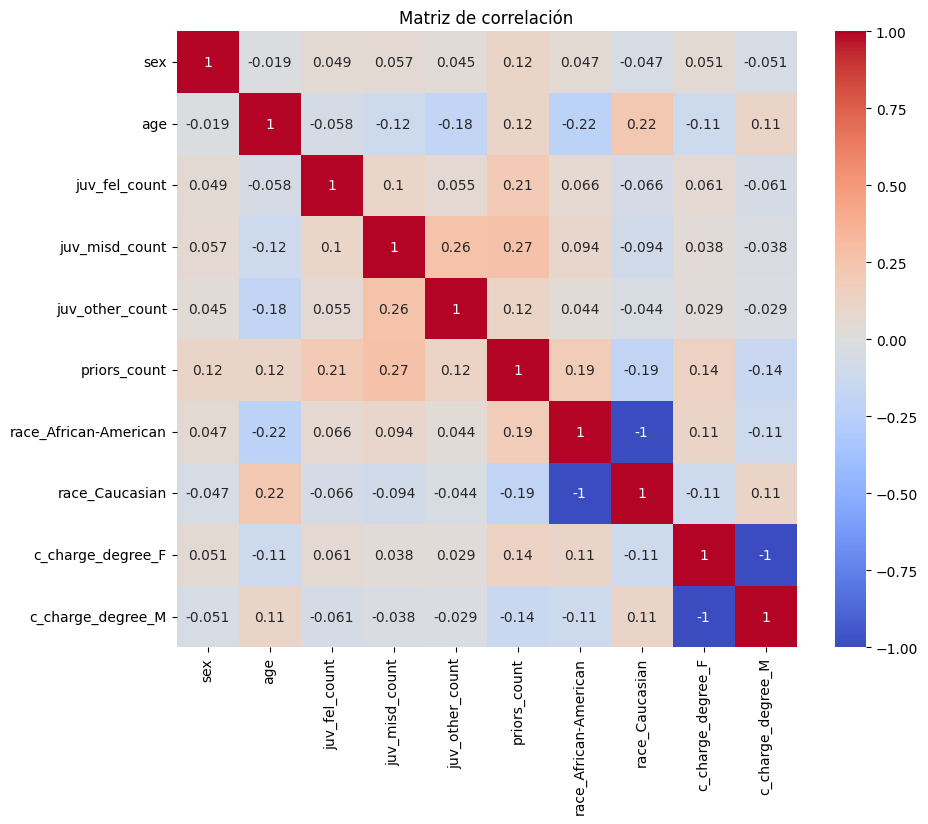

In [93]:
corr = X_train_full.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True,
 cmap="coolwarm", center=0)
plt.title("Matriz de correlación")
plt.show()


**Mayoría de correlaciones entre -0.2 y +0.3**:
- No hay multicolinealidad fuerte (no hay pares > 0.8).
- Las variables son moderadamente independientes, lo que favorece tanto modelos lineales como GAMs.

**Observación específica**:
- ``age`` vs ``juv_misd_count`` (-0.12): Los más jóvenes tienden a más delitos menores → posible efecto no lineal con la edad.
- ``juv_misd_count`` vs ``juv_other_count`` (0.26): Ligera correlación
- ``priors_count`` vs ``juv_misd_count`` (0.27): Más antecedentes, más delitos previos; puede haber saturación (no linealidad).
- Perfectamente correlacionadas variables de grado de cargo criminal F (felony) y M (misdemeanor) -> ya que si tiene cargo F, no lo tendrà M
- Igual correlacionadas, persona es afroamericana o caucasica -> ya que si es afroamericano, no es caucasico

Estos dos últimos casos los vamos a juntar, ya que se puede representar en una sola variable.

In [94]:
# Función para aplicar las mismas transformaciones a cualquier dataframe
def preprocess_data(df):
    X = df.copy()
    # Unificar las variables correlacionadas si existen
    if "race_Caucasian" in X.columns and "c_charge_degree_M" in X.columns:
        X = X.drop(columns=["race_Caucasian", "c_charge_degree_M"])
        X = X.rename(columns={
            "race_African-American": "is_AfricanAmerican_vs_Caucasian",
            "c_charge_degree_F": "is_Felony_vs_Misdemeanor"
        })
    return X

# Preprocesar ambos datasets para que tengan la misma estructura
X_train_processed = preprocess_data(X_train_full)
X_test_processed = preprocess_data(df_test)

# Asegurar que las columnas estén en el mismo orden
# Esto es crucial para que el modelo haga las predicciones correctamente
X_test_processed = X_test_processed[X_train_processed.columns]


In [95]:
try:
  print(X_train_processed.shape)
except Exception:
  print("fallo, no numpy")

try:
  print(X_train_processed.head())
  print(X_train_processed.columns)
except Exception:
  print("fallo, no pandas")

(4222, 9)
   sex  age  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0    0   45              0               0                0             1   
1    1   43              0               0                0             2   
2    0   26              0               0                0             0   
3    1   35              0               0                0             1   
4    1   27              0               0                0             0   

   is_AfricanAmerican_vs_Caucasian  is_Felony_vs_Misdemeanor  employment  
0                                0                         1  unemployed  
1                                1                         0  unemployed  
2                                1                         1    employed  
3                                0                         1  unemployed  
4                                1                         1  unemployed  
Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
  

Ahora los valores de ``is_AfricanAmerican_vs_Caucasian`` y ``is_Felony_vs_Misdemeanor`` van a ser:
- 1 = African-American, 0 = Caucasian
- 1 = Felony, 0 = Misdemeanor

Aquí podemos ver como se han modificado las variables:

In [96]:
X_train_processed.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_AfricanAmerican_vs_Caucasian,is_Felony_vs_Misdemeanor,employment
0,0,45,0,0,0,1,0,1,unemployed
1,1,43,0,0,0,2,1,0,unemployed
2,0,26,0,0,0,0,1,1,employed
3,1,35,0,0,0,1,0,1,unemployed
4,1,27,0,0,0,0,1,1,unemployed


## Correlación entre variables y objetivo


--- Generando Cuadrícula de Gráficos de Linealidad con Suavizado LOESS ---


/usr/local/lib/python3.12/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide



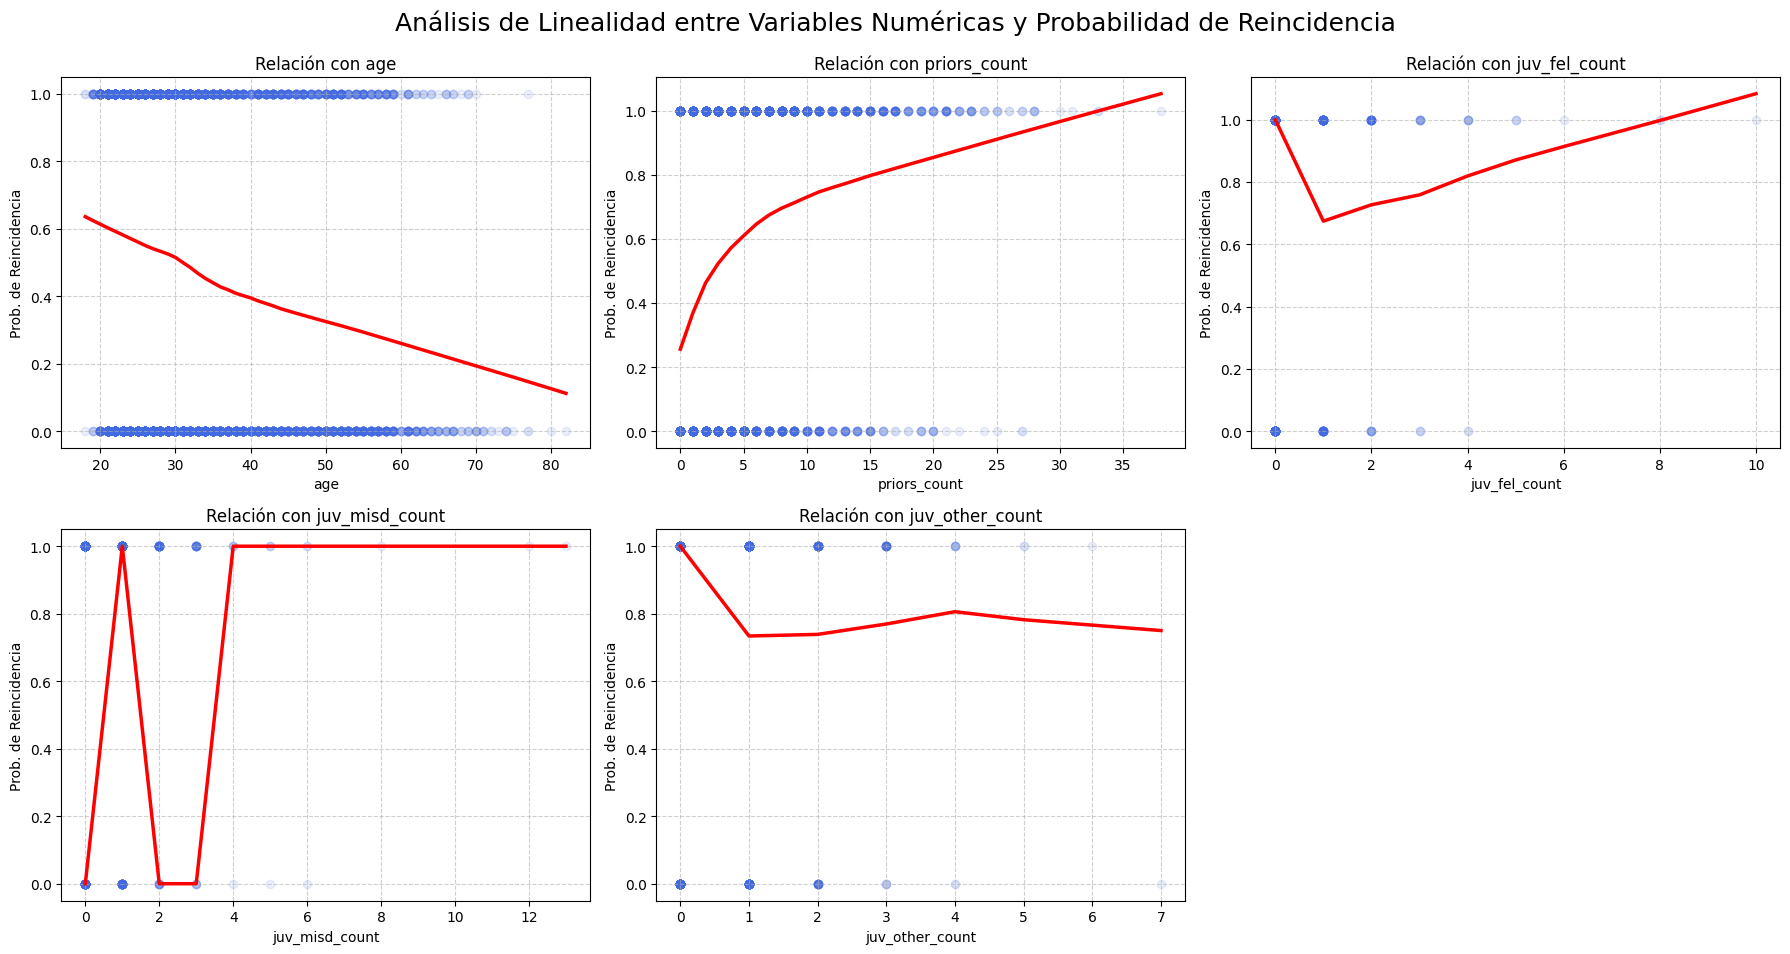

In [97]:
# Lista de variables numéricas a analizar
numeric_features = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

print("\n--- Generando Cuadrícula de Gráficos de Linealidad con Suavizado LOESS ---")

# Crear una cuadrícula de 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# Aplanar el array de ejes para iterar fácilmente
axes = axes.flatten()

# Generar cada gráfico en su respectivo eje
for i, feature in enumerate(numeric_features):
    ax = axes[i]
    sns.regplot(x=feature, y=y_train_full, data=X_train_processed,
                lowess=True,
                scatter_kws={'alpha': 0.1, 'color': 'royalblue'},
                line_kws={'color': 'red', 'linewidth': 2.5},
                ax=ax)
    ax.set_title(f'Relación con {feature}', fontsize=12)
    ax.set_ylabel('Prob. de Reincidencia')
    ax.set_xlabel(feature)
    ax.grid(True, linestyle='--', alpha=0.6)

# Ocultar ejes que no se usan
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Ajustar el layout y añadir un título general
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Análisis de Linealidad entre Variables Numéricas y Probabilidad de Reincidencia', fontsize=18)
plt.show()

--- Generando Cuadrícula de Gráficos de Barras ---


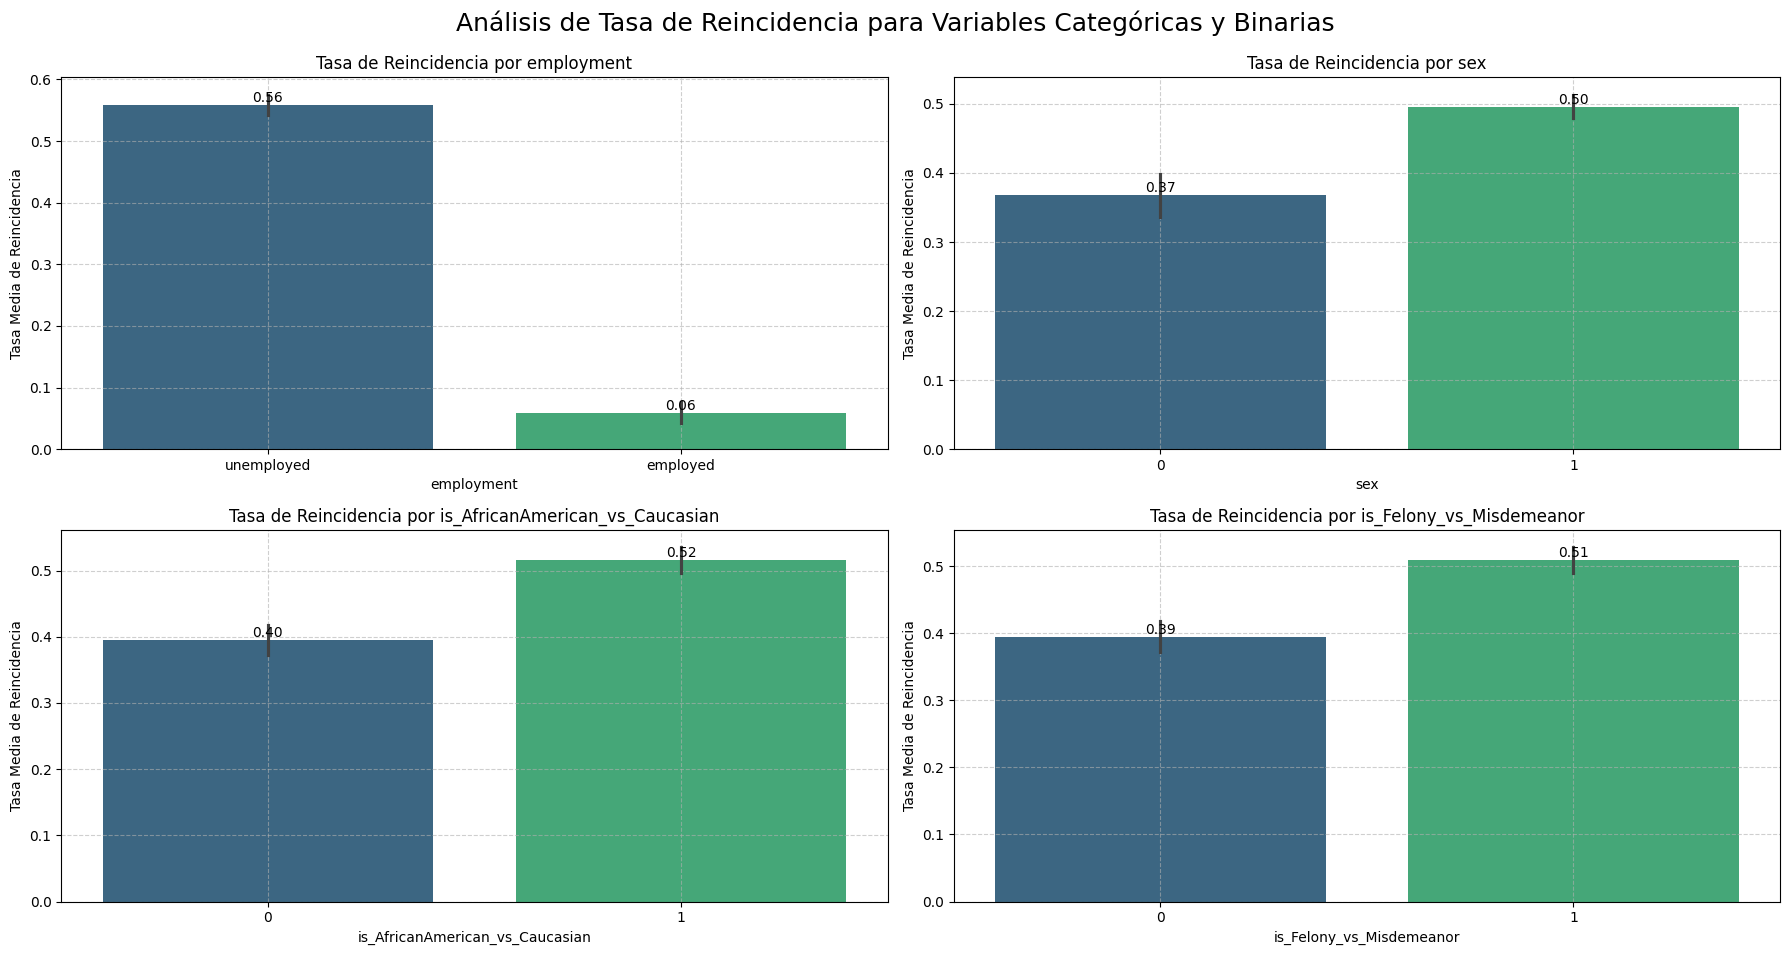

In [98]:
# Identificar columnas a graficar
categorical_features = X_train_processed.select_dtypes(include=['object', 'category']).columns.tolist()
binary_features = [col for col in X_train_processed.columns if X_train_processed[col].nunique() == 2 and col not in categorical_features]
features_to_plot = categorical_features + binary_features

print("--- Generando Cuadrícula de Gráficos de Barras ---")

# Crear una cuadrícula de 2 filas y 3 columnas
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
# Aplanar el array de ejes para iterar fácilmente
axes = axes.flatten()

# Generar cada gráfico en su respectivo eje
for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    sns.barplot(x=feature, y=y_train_full, data=X_train_processed, palette='viridis', ax=ax)
    ax.set_title(f'Tasa de Reincidencia por {feature}', fontsize=12)
    ax.set_ylabel('Tasa Media de Reincidencia')
    ax.set_xlabel(feature)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Añadir etiquetas con valores
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Ocultar ejes que no se usan (si el número de gráficos no llena la cuadrícula)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Ajustar el layout para evitar solapamientos y añadir un título general
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Análisis de Tasa de Reincidencia para Variables Categóricas y Binarias', fontsize=18)
plt.show()

- **Empleo**: estar desempleado multiplica casi por diez la probabilidad de reincidir en este dataset. Esta es una señal predictiva muy potente.
- **Otras**: impacto individual es mucho menor en comparación con el del empleo.

Gracias a este estudio, ahora podemos entender como en el árbol de desicion se elige la variable del empleo como nodo raíz, ya que es el qie mejor separa los datos en grupos con diferentes probabilidades de reincidencia.

Observando las anteriores gráficas, podemos concluir que el mejor modelo a elegir es el de la GAM, ya que los modelos lineales asumen que la relación entre cada variable predictora y el resultado es una línea recta, mientras que los GAMs son flexibles y pueden modelar relaciones curvas (no lineales). En el análisis anterior, hemos podido observar que simpre hay variables con relaciones no lineales.

Con GAM podemos conseguir un gran poder predictivo, mucha interpretabilidad y más flexibilidad.

In [99]:
!pip install -q interpret

In [100]:
# Dividir en train (70%) y test/valid (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_processed, y_train_full,
    test_size=0.30,         # porcentaje para el test
    random_state=42,        # semilla para reproducibilidad
    stratify=y_train_full              # asegura que las proporciones de clases se mantengan
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (2955, 9) (2955,)
Test shape: (1267, 9) (1267,)


# GAM


Iniciando GridSearchCV para EBM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- Resultados del GridSearchCV para EBM ---
Mejores parámetros encontrados:
{'interactions': 5, 'learning_rate': 0.05, 'max_bins': 64}

Mejor puntuación (balanced_accuracy) en validación cruzada: 0.7191

--- Evaluación del Mejor Modelo EBM en el Conjunto de Test ---
Accuracy (test): 0.7206
Balanced Accuracy (test): 0.7235

== Classification report (test) ==
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       674
           1       0.68      0.77      0.72       593

    accuracy                           0.72      1267
   macro avg       0.72      0.72      0.72      1267
weighted avg       0.73      0.72      0.72      1267



[]

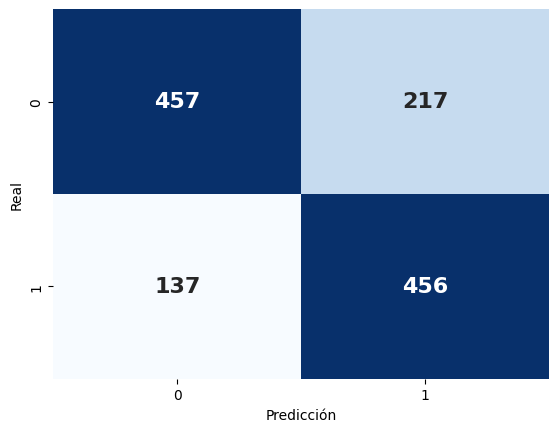

In [128]:
# --- 4. Definición de la Rejilla de Parámetros para EBM ---
# --------------------------------------------------------
# NOTA: Esta es una rejilla reducida para que se ejecute rápido.
# En un proyecto real, podrías explorar rangos más amplios.
param_grid_ebm = {
    'learning_rate': [0.01, 0.05],
    'max_bins': [32, 64, 128],
    'interactions': [0, 5]  # 0 = GAM puro, 5 = GAM con 5 mejores interacciones
}

# Esquema de validación cruzada estratificada
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 5. Ejecución del GridSearchCV ---
# -----------------------------------
ebm_base = ExplainableBoostingClassifier(random_state=42)

grid_ebm = GridSearchCV(
    estimator=ebm_base,
    param_grid=param_grid_ebm,
    scoring='balanced_accuracy',  # Métrica robusta ante desbalance
    cv=cv_stratified,
    n_jobs=-1,  # Usar todos los núcleos de CPU
    verbose=1
)

print("\nIniciando GridSearchCV para EBM...")
grid_ebm.fit(X_train, y_train)

# --- 6. Resultados y Evaluación ---
# ----------------------------------
print("\n--- Resultados del GridSearchCV para EBM ---")
print("Mejores parámetros encontrados:")
print(grid_ebm.best_params_)
print(f"\nMejor puntuación (balanced_accuracy) en validación cruzada: {grid_ebm.best_score_:.4f}")

# Evaluar el mejor modelo encontrado en el conjunto de test
best_ebm = grid_ebm.best_estimator_
y_pred_best = best_ebm.predict(X_test)

print("\n--- Evaluación del Mejor Modelo EBM en el Conjunto de Test ---")
print(f"Accuracy (test): {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Balanced Accuracy (test): {balanced_accuracy_score(y_test, y_pred_best):.4f}")
print("\n== Classification report (test) ==")
print(classification_report(y_test, y_pred_best))
cm = confusion_matrix(y_test, y_pred_best)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16, "weight": "bold"});ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.plot()


El modelo EBM ha demostrado un rendimiento sólido y equilibrado en el conjunto de prueba, con una Precisión Balanceada (Balanced Accuracy) de 0.7235.

- **Rendimiento Equilibrado**: El modelo funciona bien tanto para predecir la reincidencia como la no reincidencia. Esto se confirma al observar que los f1-score para ambas clases son idénticos (0.72), y la Balanced Accuracy (72.4%) es muy similar a la Accuracy general (72.1%).

- **Fortaleza en la Detección de Riesgo**: La principal fortaleza del modelo es su capacidad para identificar a los individuos que efectivamente reinciden, logrando un recall del 77% para la clase 1. Esto lo hace una herramienta valiosa para la detección de riesgo.

- **Fiabilidad en Predicciones de No Reincidencia**: Cuando el modelo predice que una persona no reincidirá (clase 0), su fiabilidad es alta, con una precision del 77%

In [102]:
# --- 7. Explicabilidad del Modelo Optimizado ---
# ---------------------------------------------
print("\n--- Generando Explicación Global del Modelo EBM Optimizado ---")
ebm_global_optimized = best_ebm.explain_global(name='EBM_Optimized_Global')
show(ebm_global_optimized)


--- Generando Explicación Global del Modelo EBM Optimizado ---


## Interpretabilidad a nivel global (GAM)
El modelo ha identificado una jerarquía clara en la importancia de las variables. Las tres características más determinantes, por un amplio margen, son:

- **employment (Empleo)**: Con una puntuación de aproximadamente 0.86, esta es, con diferencia, la variable más influyente. El estado laboral (empleado o desempleado) es el factor principal que utiliza el modelo para estimar el riesgo de reincidencia.

- **priors_count (Número de antecedentes)**: Es el segundo predictor más potente, con una puntuación cercana a 0.52. El historial delictivo de una persona es un factor crucial en la predicción.

- **age (Edad)**: La edad del individuo es la tercera variable más relevante, con una puntuación aproximada de 0.4. Esto confirma la hipótesis de tu análisis de linealidad de que la edad tiene una relación significativa (probablemente no lineal) con la reincidencia.

El modelo EBM no solo analiza variables de forma aislada, sino que también ha detectado interacciones significativas. La más importante es ``sex`` & ``employment``, lo que sugiere que el efecto del género sobre la reincidencia depende del estado laboral de la persona (y viceversa). Otras interacciones como ``age`` & ``is_AfricanAmerican_vs_Caucasian`` también aportan valor, aunque en menor medida.

Además, características como el sexo, el tipo de cargo (``is_Felony_vs_Misdemeanor``) y el historial de delitos juveniles (``juv_other_count``, ``juv_misd_count``) tienen un impacto moderado. La variable con menor peso en el modelo es ``juv_fel_count`` (delitos graves juveniles).

In [103]:
print("\n--- Generando Explicación Local para 5 casos ---")
ebm_local = best_ebm.explain_local(X_test[:5], y_test[:5], name='EBM_Local')
show(ebm_local)


--- Generando Explicación Local para 5 casos ---


### **Caso 0: Falso Positivo (Predicción = 1 | Real = 0)**
- El modelo predice Reincidencia (1) con una probabilidad del 65.6%.

Factores Clave de Riesgo (Naranja):

- Estar desempleado es, con diferencia, el factor que más aumenta el riesgo.

- Tener 3 antecedentes también contribuye significativamente al riesgo.

- Una edad relativamente joven (28 años) suma una cantidad considerable de riesgo.

Factores Mitigantes (Azul):

- Ser hombre (valor 1) reduce ligeramente el riesgo en este caso.

El modelo se equivoca en esta predicción (falso positivo) porque el gran peso negativo del desempleo, combinado con el historial de antecedentes y la edad, supera a los factores mitigantes. Esto demuestra la alta sensibilidad del modelo a la variable employment.

### **Caso 1: Verdadero Negativo (Predicción = 0 | Real = 0)**
- El modelo predice No Reincidencia (0) con una probabilidad del 62.2%.

Factores Clave de Riesgo (Naranja):

- Nuevamente, el desempleo es el principal factor que aumenta el riesgo.

- Una interacción entre la edad y la raza contribuye ligeramente al riesgo.

Factores Mitigantes (Azul):

- A los 44 años, la edad tiene un fuerte impacto negativo, reduciendo considerablemente el riesgo.
- Un historial de solo 2 antecedentes también ayuda a disminuir la puntuación.

El modelo acierta en esta predicción. Aunque la persona está desempleada, su edad madura (44 años) es un factor protector tan fuerte que contrarresta el riesgo del desempleo, llevando la predicción final hacia la no reincidencia.

### **Caso 2: Verdadero Positivo (Predicción = 1 | Real = 1)**
- El modelo predice Reincidencia (1) con una alta confianza (probabilidad del 86.8%).

Factores Clave de Riesgo (Naranja):

- Un historial de 23 antecedentes es el factor más abrumadoramente negativo.

- Estar desempleado añade un riesgo adicional muy significativo.

- Tener un historial de delitos menores juveniles también suma riesgo.

Factores Mitigantes (Azul):

- La mayoría de los demás factores, como age (35.00), tienen un impacto negativo, pero son completamente insignificantes en comparación con el peso del historial delictivo.

El modelo acierta con una confianza muy alta. El extenso historial de antecedentes es tan determinante que cualquier otro factor se vuelve prácticamente irrelevante.

### **Caso 3: Falso Negativo (Predicción = 0 | Real = 1)**
- El modelo predice No Reincidencia (0) con una confianza del 78.1%.

Factores Clave de Riesgo (Naranja):

- El desempleo es el único factor que empuja significativamente hacia la reincidencia.

Factores Mitigantes (Azul):

- La edad avanzada (57 años) es el factor más fuerte que reduce el riesgo.

- Un bajo número de antecedentes también contribuye a una predicción de bajo riesgo.

En este caso, el modelo se equivoca. El gran peso protector de la edad avanzada hace que el modelo "perdone" el riesgo asociado al desempleo. Es un ejemplo de un perfil complejo donde el modelo prioriza un factor sobre otro para tomar su decisión, aunque en esta ocasión resulte incorrecta.

### **Caso 4: Verdadero Negativo (Predicción = 0 | Real = 0)**
- El modelo predice No Reincidencia (0) con una probabilidad del 57.2%.

Factores Clave de Riesgo (Naranja):

- El desempleo es el principal factor de riesgo.

- Un cargo por delito menor (Misdemeanor) añade un pequeño riesgo.

Factores Mitigantes (Azul):

- No tener antecedentes es el factor protector más fuerte.

- A los 30 años, la edad tiene un impacto negativo moderado.

El modelo acierta. Aunque la persona está desempleada (lo que siempre suma riesgo), el hecho de no tener ningún antecedente previo es un factor tan positivo que anula el riesgo del desempleo y lleva la predicción a no reincidir. Esto demuestra que el modelo es capaz de equilibrar factores opuestos de manera efectiva.

# Modelo lineal

\nIniciando GridSearchCV para Regresión Logística...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
\n--- Resultados del GridSearchCV para Regresión Logística ---
Mejores parámetros encontrados:
{'classifier__C': 10}
\nMejor puntuación (balanced_accuracy) en validación cruzada: 0.7147
\n--- Evaluación del Modelo de Regresión Logística en el Conjunto de Test ---
Accuracy (test): 0.7017
Balanced Accuracy (test): 0.7067
\n== Classification report (test) ==
              precision    recall  f1-score   support

           0       0.77      0.63      0.69       674
           1       0.65      0.79      0.71       593

    accuracy                           0.70      1267
   macro avg       0.71      0.71      0.70      1267
weighted avg       0.71      0.70      0.70      1267



[]

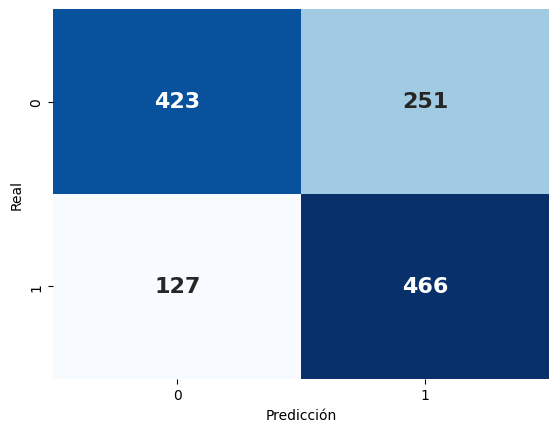

In [127]:
# --- 3. Preprocesamiento para Modelo Lineal ---
# (Importaciones adicionales para el gráfico)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Identificar tipos de columnas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Crear transformadores (StandardScaler para numéricas, OneHotEncoder para categóricas)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 4. Definición del Pipeline y GridSearchCV ---
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# Definir la rejilla de parámetros
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Configurar el GridSearchCV
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_lr = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid_lr,
    scoring='balanced_accuracy',
    cv=cv_stratified,
    n_jobs=-1,
    verbose=1
)

print("\\nIniciando GridSearchCV para Regresión Logística...")
grid_lr.fit(X_train, y_train)

# --- 5. Resultados y Evaluación ---
print("\\n--- Resultados del GridSearchCV para Regresión Logística ---")
print("Mejores parámetros encontrados:")
print(grid_lr.best_params_)
print(f"\\nMejor puntuación (balanced_accuracy) en validación cruzada: {grid_lr.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de test
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("\\n--- Evaluación del Modelo de Regresión Logística en el Conjunto de Test ---")
print(f"Accuracy (test): {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Balanced Accuracy (test): {balanced_accuracy_score(y_test, y_pred_lr):.4f}")
print("\\n== Classification report (test) ==")
print(classification_report(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16, "weight": "bold"});ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.plot()


In [105]:
X_modified, y_modified, best_lr_modified = X_train_processed, y_train_full, best_lr

El modelo lineal optimizado funciona como un sólido punto de referencia, alcanzando una Precisión Balanceada (Balanced Accuracy) de 70.67%.

- **Buen Detector de Reincidencia**: La principal fortaleza del modelo es su alta capacidad para identificar a los individuos que efectivamente reinciden, logrando un recall del 79% para la clase 1.

- **Rendimiento Desigual**: Aunque es bueno detectando reincidentes, tiene más dificultades para identificar correctamente a todos los que no reinciden, con un recall del 63% para la clase 0. Esto indica una mayor tendencia a generar "falsas alarmas" en comparación con el modelo GAM.

- **Conclusión**: Es un modelo útil, pero su rendimiento general es inferior al del GAM, lo que sugiere que su incapacidad para modelar las relaciones no lineales limita su precisión.

\n--- Generando Gráfico de Importancia Global para el Modelo Lineal ---


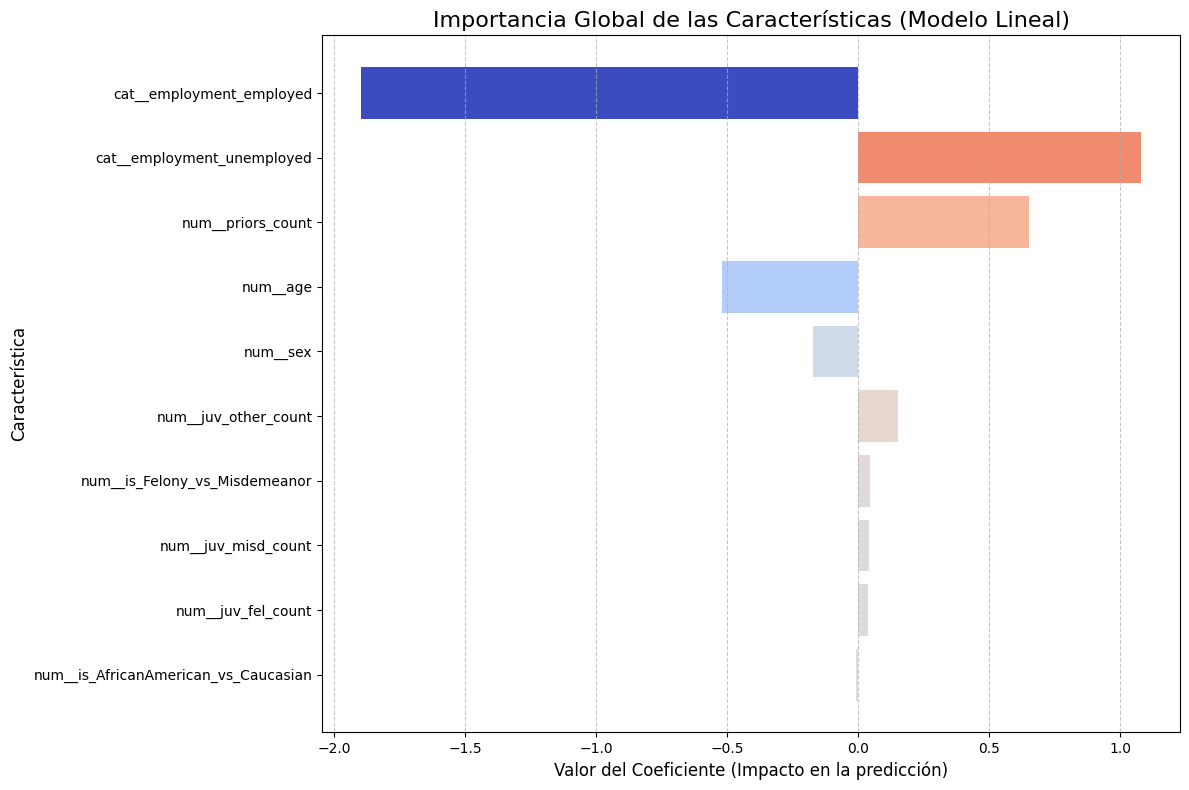

In [106]:
# --- 6. EXPLICABILIDAD GLOBAL (Gráfico de Coeficientes) ---
# ---------------------------------------------------------
print("\\n--- Generando Gráfico de Importancia Global para el Modelo Lineal ---")

# Extraer el clasificador y el preprocesador del mejor pipeline
classifier_fitted = best_lr.named_steps['classifier']
preprocessor_fitted = best_lr.named_steps['preprocessor']

# Obtener los nombres de las características después del preprocesamiento
feature_names = preprocessor_fitted.get_feature_names_out()

# Obtener los coeficientes del modelo
coefficients = classifier_fitted.coef_[0]

# Crear un DataFrame para facilitar la visualización
coef_df = pd.DataFrame({'Característica': feature_names, 'Coeficiente': coefficients})

# Ordenar por el valor absoluto del coeficiente para ver la importancia
coef_df['Importancia'] = abs(coef_df['Coeficiente'])
coef_df = coef_df.sort_values(by='Importancia', ascending=True)

# Visualizar los coeficientes en un gráfico de barras horizontales
plt.figure(figsize=(12, 8))
plt.barh(coef_df['Característica'], coef_df['Coeficiente'], color=plt.cm.coolwarm(0.5 + coef_df['Coeficiente'] / (2 * max(coef_df['Importancia']))))
plt.title('Importancia Global de las Características (Modelo Lineal)', fontsize=16)
plt.xlabel('Valor del Coeficiente (Impacto en la predicción)', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El modelo ha identificado una jerarquía muy clara sobre qué factores son los más decisivos:

- ``employment`` (Situación laboral): Esta es, con una diferencia abrumadora, la característica más importante.

- ``cat__employment_unemployed``: Tiene el coeficiente positivo más alto (aproximadamente +1.0). Ser desempleado es el factor que más empuja la predicción hacia la reincidencia.

- ``cat__employment_employed``: Tiene el coeficiente negativo más grande (cercano a -1.9). Estar empleado es el factor protector más fuerte contra la reincidencia.

- ``priors_count`` (Número de antecedentes): Es el segundo factor de riesgo más importante. Su coeficiente positivo (aproximadamente +0.6) indica que a mayor número de antecedentes, mayor es la probabilidad predicha de reincidir.

- ``age`` (Edad): Es el factor protector más relevante después del empleo. Su coeficiente negativo (alrededor de -0.5) sugiere que, para este modelo, a mayor edad, menor es la probabilidad de reincidencia.

Variables como ``num__sex`` y ``num__juv_other_count`` tienen un impacto negativo (protector), pero su influencia es considerablemente menor que la de la edad o el empleo.

El resto de las características, como ``is_Felony_vs_Misdemeanor``, ``juv_misd_count``, ``juv_fel_count`` y ``is_AfricanAmerican_vs_Caucasian``, tienen coeficientes muy cercanos a cero. Esto significa que, según este modelo lineal, estas variables tienen un impacto casi nulo en la predicción final.

In [107]:
# --- 6. Explicabilidad del Modelo Lineal con la Librería 'interpret' ---

# --- Importaciones Adicionales ---
from interpret import show
from interpret.blackbox import LimeTabular, PartialDependence
import pandas as pd
import warnings

# Ignorar advertencias futuras que pueden aparecer en las librerías
warnings.filterwarnings("ignore", category=FutureWarning)

print("\n--- Preparando datos para los Explainers de 'interpret' ---")

# --- Paso Clave: Preprocesar los datos ANTES de pasarlos a los explicadores ---
# 1. Extraemos el pipeline y el preprocesador ya entrenados
best_lr_pipeline = grid_lr.best_estimator_
preprocessor_fitted = best_lr_pipeline.named_steps['preprocessor']
classifier_fitted = best_lr_pipeline.named_steps['classifier']

# 2. Obtenemos los nombres de las columnas después del One-Hot Encoding
feature_names = preprocessor_fitted.get_feature_names_out()

# 3. Transformamos nuestros datos de train y test a formato numérico
X_train_processed = preprocessor_fitted.transform(X_train)
X_test_processed = preprocessor_fitted.transform(X_test)

# 4. Los convertimos a DataFrames de Pandas para que los gráficos sean legibles
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Datos preprocesados y listos para la interpretación.")

# --- Explicabilidad Global (Partial Dependence Plot) ---
print("\nGenerando explicación global...")

# Le pasamos el CLASIFICADOR (ya no el pipeline) y los DATOS PROCESADOS
pdp = PartialDependence(
    model=classifier_fitted,
    data=X_train_processed_df
)
global_explanation = pdp.explain_global(name='Regresión Logística - Global')
show(global_explanation)


--- Preparando datos para los Explainers de 'interpret' ---
Datos preprocesados y listos para la interpretación.

Generando explicación global...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr

### **Caso 0: Falso Positivo (Real = 0 | Predicción = 1)**
- El modelo predice Reincidencia (1) con una probabilidad del 59.9%. Sin embargo, el valor real era 0, por lo que es un falso positivo.

Factores que Apoyan la Predicción (Naranja):

- El factor más influyente es estar desempleado, que aumenta considerablemente el riesgo.

- Una edad inferior a la media también contribuye al riesgo.

Factores que Contradicen la Predicción (Azul):

- No tener un historial de otros delitos juveniles es el principal factor que reduce el riesgo.

El modelo se equivoca al clasificar a esta persona como reincidente. El gran peso que le da al desempleo y a una edad relativamente joven supera a los factores protectores, llevando a una predicción incorrecta.

### **Caso 1: Verdadero Negativo (Real = 0 | Predicción = 0)**
- El modelo predice No Reincidencia (0) con una probabilidad del 37.1%. La predicción es correcta.

Factores que Apoyan la Predicción (Naranja):

- De nuevo, estar desempleado es el principal factor de riesgo.

Factores que Contradicen la Predicción (Azul):

- Una edad superior a la media es el factor más fuerte que empuja la predicción hacia la no reincidencia.

- Un número de antecedentes por debajo de la media también reduce significativamente el riesgo.

El modelo acierta. A pesar de que la persona está desempleada, su edad más avanzada y su historial de antecedentes favorable son factores protectores suficientes para que el modelo lo clasifique correctamente como de bajo riesgo.

### **Caso 2: Verdadero Positivo (Real = 1 | Predicción = 1)**
- El modelo predice Reincidencia (1) con una confianza muy alta (94.6%). La predicción es correcta.

Factores que Apoyan la Predicción (Naranja):

- Estar desempleado.

- Un número de antecedentes muy por encima de la media (valor estandarizado de 4.07) es el factor más decisivo.

Factores que Contradicen la Predicción (Azul):

- La ausencia de otros delitos juveniles reduce ligeramente el riesgo, pero su efecto es mínimo.

Un acierto claro del modelo. El extenso historial de antecedentes previos es tan determinante que, combinado con el desempleo, hace que la predicción de reincidencia sea casi segura.

### **Caso 3: Falso Negativo (Real = 1 | Predicción = 0)**
- El modelo predice No Reincidencia (0) con una probabilidad del 17.7%. La predicción es incorrecta.

Factores que Apoyan la Predicción (Naranja):

- El desempleo es el principal factor de riesgo.

Factores que Contradicen la Predicción (Azul):

- Una edad muy superior a la media es un factor protector extremadamente fuerte.

- Un bajo número de antecedentes también reduce el riesgo.

Este es un falso negativo. El modelo se equivoca porque le da un peso tan grande a la edad avanzada como factor protector que acaba ignorando el riesgo asociado al desempleo, resultando en una predicción incorrecta.

### **Caso 4: Falso Positivo (Real = 0 | Predicción = 1)**
- El modelo predice Reincidencia (1) con una probabilidad del 55.3%, pero el valor real era 0. Es un falso positivo.

Factores que Apoyan la Predicción (Naranja):

- Una vez más, el desempleo es el factor de riesgo más importante.

- Una edad ligeramente inferior a la media también suma riesgo.

Factores que Contradicen la Predicción (Azul):

- Un número de antecedentes muy por debajo de la media es el factor protector más fuerte.

El modelo falla al sobrestimar el riesgo. Aunque el individuo tiene un buen historial (priors_count bajo), el modelo le da más importancia a la combinación de desempleo y juventud relativa.

In [108]:
!pip install lime

In [109]:
# --- Explicabilidad Local (LIME) ---
print("\nGenerando explicación local para 5 casos...")

# LIME necesita una función que prediga probabilidades.
# Le pasamos la función del CLASIFICADOR y los DATOS PROCESADOS de entrenamiento.
lime = LimeTabular(
    model=classifier_fitted.predict_proba,
    data=X_train_processed_df
)

# Explicamos las primeras 5 instancias del conjunto de test PROCESADO
local_explanation = lime.explain_local(
    X_test_processed_df[:5],
    y_test[:5],
    name='Regresión Logística - Local'
)
show(local_explanation)


Generando explicación local para 5 casos...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr

## Conclusiones: ¿Qué es mejor, modelo lineal o modelo GAM?

- El GAM (EBM) es el ganador: Con una Balanced Accuracy del 72.35%, el GAM es el modelo con el mejor rendimiento general. Aunque la diferencia no es abismal, es una mejora clara y consistente sobre los otros dos modelos.

- ¿Por qué gana el GAM?: Su principal ventaja es que logra el mejor equilibrio. Es casi tan bueno como los otros modelos para detectar a los que sí reinciden (Recall del 77%), pero es significativamente mejor para identificar correctamente a los que no van a reincidir (Recall del 68%). En otras palabras, genera menos "falsas alarmas" que los otros dos.

- El Modelo Lineal es un Buen Baseline, pero Limitado: La Regresión Logística (70.67%) funciona ligeramente mejor que el Árbol de Decisión (70.19%). Demuestra ser un modelo base sólido. Sin embargo, su rendimiento inferior al del GAM confirma nuestra hipótesis inicial: al no poder modelar las relaciones curvas de la edad y el número de antecedentes, pierde algo de precisión.

- Conclusión Final: Rendimiento + Interpretabilidad: El GAM (EBM) no solo ha demostrado ser el modelo más preciso, sino que también ofrece una interpretabilidad superior al permitirnos visualizar y entender las complejas relaciones no lineales de los datos. La mejora en las métricas es la prueba cuantitativa de que capturar esas curvas (algo que el modelo lineal no puede hacer) es beneficioso para el rendimiento del modelo.

# Generar predicciones
Una vez tenemos el mejor modelo (GAM), lo que realizamos es un entrenamiento (usando los mejores parámetros del *gridSearch*) con todos los datos del dataset ``recidivism.csv`` y aplicamos las predicciones en los datos del dataset ``test.csv``. Estas predicciones las añadimos en la columna ``recid`` del dataset de test, formando así un nuevo dataset con los datos y sus predicciones llamado ``test_predictions_completed.csv``.

In [123]:
#-----------------------------------------
X_train_export = preprocess_data(df_train.drop(columns=["recid"]))
y_train_export = df_train["recid"]

X_test_export = preprocess_data(df_test.drop(columns=["recid"]))
y_test_export = df_test["recid"]


# ----------------------------------------
print("\nEntrenando el modelo EBM final con los datos completos de entrenamiento...")
final_ebm_model = ExplainableBoostingClassifier(
    random_state=42,
    learning_rate=0.05,
    max_bins=64,
    interactions=5
)
final_ebm_model.fit(X_train_export, y_train_export)

# --- 5. Generación de Predicciones ---
# ------------------------------------
print("Generando predicciones para el nuevo conjunto de test...")
predictions = final_ebm_model.predict(X_test_export)

# --- 6. Creación del Archivo de Entrega ---
# ------------------------------------------
# Carga de nuevo el dataset de test original para añadir la columna de predicción
df_test_final = pd.read_csv("test.csv")

# Añadir la columna 'recid' con las predicciones
df_test_final['recid'] = predictions

# Guardar el DataFrame completo en un archivo CSV sin el índice
submission_filename = 'test_predictions_completed.csv'
df_test_final.to_csv(submission_filename, index=False)

print(f"\n¡Proceso completado! Se ha generado el archivo '{submission_filename}'.")
print("Este archivo contiene todos los datos de test más la columna 'recid' con las predicciones.")
print("\nPrimeras 5 filas del archivo final:")
print(df_test_final.head())


Entrenando el modelo EBM final con los datos completos de entrenamiento...
Generando predicciones para el nuevo conjunto de test...

¡Proceso completado! Se ha generado el archivo 'test_predictions_completed.csv'.
Este archivo contiene todos los datos de test más la columna 'recid' con las predicciones.

Primeras 5 filas del archivo final:
   sex  age  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0    0   39              0               0                0             0   
1    1   27              0               0                0             0   
2    1   23              0               0                0             3   
3    1   31              0               0                0             7   
4    0   21              0               0                0             0   

   race_African-American  race_Caucasian  c_charge_degree_F  \
0                      0               1                  0   
1                      0               1                  1   
2    

# Generación de Comparativa para el report

Por último hacemos la comparativa para el report donde comparamos todos los modelos sobre un 5-fold y generamos una predicción sobre train. Con esto tenemos datos comparados para los tres mejores modelos de cada técnica.

In [126]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

# === Configuración de validación cruzada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(accuracy_score)

# Quita el preprocesador del pipeline (primer paso)
best_lr_no_pre = Pipeline(best_lr_modified.steps[1:])

# Datasets distintos según el modelo
models = {
    "Logistic Regression": best_lr_no_pre,   # sin preprocesador
    "Decision Tree": best_clf,
    "Explainable Boosting Machine (EBM)": best_ebm
}

# === Resultados ===
results = {}

for name, model in models.items():
    # Selección de datos según el modelo
    if name == "Logistic Regression":
        X_used, y_used = X_train_processed, y_train
    else:
        X_used, y_used = X, y

    # Si X_used no es DataFrame, lo convertimos genéricamente
    if not isinstance(X_used, pd.DataFrame):
        X_used = pd.DataFrame(X_used, columns=[f"col_{i}" for i in range(X_used.shape[1])])

    # --- 5-fold CV ---
    scores = cross_val_score(model, X_used, y_used, cv=cv)
    mean_cv = np.mean(scores)
    std_cv = np.std(scores)

    # --- Train accuracy ---
    model.fit(X_used, y_used)
    y_pred_train = model.predict(X_used)
    acc_train = accuracy_score(y_used, y_pred_train)

    # --- Guardamos todo ---
    results[name] = {
        "Train accuracy": acc_train,
        "5-fold CV mean": mean_cv,
        "5-fold CV std": std_cv
    }

    # --- Mostrar en pantalla ---
    print(f"🔹 {name}")
    print(f"  Train accuracy: {acc_train:.4f}")
    print(f"  Accuracy por fold: {np.round(scores, 4)}")
    print(f"  Media (5-fold CV): {mean_cv:.4f} ± {std_cv:.4f}\n")

# === DataFrame final ===
df_results = pd.DataFrame([
    {
        "Model": name,
        "Train accuracy": res["Train accuracy"],
        "5-fold CV mean": res["5-fold CV mean"],
        "5-fold CV std": res["5-fold CV std"]
    }
    for name, res in results.items()
])


🔹 Logistic Regression
  Train accuracy: 0.7161
  Accuracy por fold: [0.7343 0.7107 0.7411 0.7039 0.6717]
  Media (5-fold CV): 0.7124 ± 0.0246

🔹 Decision Tree
  Train accuracy: 0.7094
  Accuracy por fold: [0.7148 0.703  0.7204 0.6896 0.6908]
  Media (5-fold CV): 0.7037 ± 0.0124

🔹 Explainable Boosting Machine (EBM)
  Train accuracy: 0.7234
  Accuracy por fold: [0.7302 0.7124 0.7287 0.7002 0.7145]
  Media (5-fold CV): 0.7172 ± 0.0111



In [124]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np
import pandas as pd

# Definimos el validador 5-fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(accuracy_score)

from sklearn.pipeline import Pipeline

# Quita el preprocesador del pipeline (primer paso)
best_lr_no_pre = Pipeline(best_lr_modified.steps[1:])

# Usa tus datasets distintos
models = {
    "Logistic Regression": best_lr_no_pre,   # sin preprocesador
    "Decision Tree": best_clf,
    "Explainable Boosting Machine (EBM)": best_ebm
}

cv_results = {}

for name, model in models.items():
    if name == "Logistic Regression":
        X_used, y_used = X_train_processed, y_train
    else:
        X_used, y_used = X, y

    # Si X_used no es DataFrame, lo convertimos genéricamente
    if not isinstance(X_used, pd.DataFrame):
        X_used = pd.DataFrame(X_used, columns=[f"col_{i}" for i in range(X_used.shape[1])])

    scores = cross_val_score(model, X_used, y_used, cv=cv)  # , scoring=scorer
    cv_results[name] = {
        "scores": scores,
        "mean_accuracy": np.mean(scores),
        "std_accuracy": np.std(scores)
    }
    print(f"🔹 {name}")
    print(f"  Accuracy por fold: {np.round(scores, 4)}")
    print(f"  Media (5-fold CV): {np.mean(scores):.4f} ± {np.std(scores):.4f}\n")


🔹 Logistic Regression
  Accuracy por fold: [0.7343 0.7107 0.7411 0.7039 0.6717]
  Media (5-fold CV): 0.7124 ± 0.0246

🔹 Decision Tree
  Accuracy por fold: [0.7148 0.703  0.7204 0.6896 0.6908]
  Media (5-fold CV): 0.7037 ± 0.0124

🔹 Explainable Boosting Machine (EBM)
  Accuracy por fold: [0.7302 0.7124 0.7287 0.7002 0.7145]
  Media (5-fold CV): 0.7172 ± 0.0111

